In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
print(os.listdir())
os.chdir('gdrive/My Drive/Ubicomp/Final')

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install onnxruntime

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


In [12]:
from datetime import datetime
import onnxruntime as ort
from Menu import menu_dictionary, ingredients
from Functions import *

In [16]:
imagesize=640
model_path = '/content/gdrive/My Drive/Ubicomp/Final/runs/segment/train3/weights/best.onnx'
image_path = '/content/gdrive/My Drive/Ubicomp/Final/UEC/images/val/3226.jpg'

num_classes=len(ingredients)
yolo_classes = ingredients

In [19]:
model = ort.InferenceSession(model_path)
img = Image.open(image_path)
img2=img.copy()

img_width, img_height = img.size;
img = img.convert("RGB");
img = img.resize((imagesize,imagesize))
input = np.array(img)
input = input.transpose(2,0,1)
input = input.reshape(1,3,imagesize,imagesize).astype('float32')
input /= 255.0

outputs = model.run(None, {"images": input})
output0 = outputs[0][0].transpose()
boxes = output0[:,0:4+num_classes]
masks = output0[:,4+num_classes:]
output1 = outputs[1][0].reshape(32, 160 * 160)
masks = np.dot(masks, output1)
boxes = np.hstack((boxes,masks))


Total ingredients: 4
Soup with a Confidence of 50.00%.
Miso Soup with a Confidence of 50.00%.


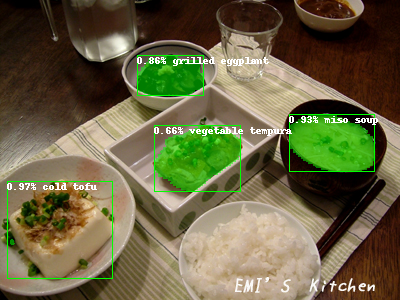

In [18]:
# parse and filter detected objects
objects = []
for row in boxes:
    prob = row[4:num_classes+4].max()
    if prob < 0.4:
        continue
    xc,yc,w,h = row[:4]
    class_id = row[4:num_classes].argmax()
    x1 = (xc-w/2)/640*img_width
    y1 = (yc-h/2)/640*img_height
    x2 = (xc+w/2)/640*img_width
    y2 = (yc+h/2)/640*img_height
    label = yolo_classes[class_id]
    mask = get_mask(row[4+num_classes:boxes.shape[1]],(x1,y1,x2,y2),img_width,img_height)
    polygon = get_polygon(mask)
    objects.append([x1,y1,x2,y2,label,prob,mask,polygon])

# apply non-maximum suppression to filter duplicated
# boxes
objects.sort(key=lambda x: x[5], reverse=True)
result = []
while len(objects)>0:
    result.append(objects[0])
    objects = [object for object in objects if iou(object,objects[0])<0.7]

print("Total ingredients:",len(result))


draw = ImageDraw.Draw(img2, "RGBA")

for object in result:
    [x1,y1,x2,y2,label,prob,mask,polygon] = object
    polygon = [(int(x1+point[0]),int(y1+point[1])) for point in polygon]
    draw.polygon(polygon,fill=(0,255,0,125))
    draw.rectangle((x1,y1,x2,y2),None,"#00ff00")
    draw.text((x1, y1), "%.2f%% %s" % (prob, label))

predicted_ingredients = labels(result)
best_matches, best_confidences = find_best_matching_dishes(predicted_ingredients, menu_dictionary)
threshold = 0.4  # Adjust the threshold based on requirements

timestamp = datetime.now().strftime("%y%m%d%H%M%S")

if best_confidences[0] >= threshold:
    print(f"{best_matches[0]} with a Confidence of {best_confidences[0]:.2%}.")
    print(f"{best_matches[1]} with a Confidence of {best_confidences[1]:.2%}.")

    img2.save(f"output/{timestamp}_{best_matches[0]}.png")
else:
    print("No dish identified.")
    print(f"The closest dishes are {best_matches[0]} with a Confidence of {best_confidences[0]:.2%} and {best_matches[1]} with a Confidence of {best_confidences[1]:.2%}.")
    img.save(f"output/{timestamp}_Unitentified.png")
img2.show()
img2